In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Playing around with Mel scale (using numpy/tf)
# https://github.com/keunwoochoi/keras_STFT_layer/blob/master/melgram.py
# https://github.com/librosa/librosa/blob/master/librosa/core/time_frequency.py

In [4]:
# Reference implementation
import cPickle as pickle

from essentia.standard import MonoLoader, FrameGenerator, Resample, Windowing, Spectrum, MelBands

wav_fp = 'SI699.WAV'

loader = MonoLoader(filename=wav_fp, sampleRate=16000.0)
window = Windowing(size=256, type='hann')
spectrum = Spectrum(size=256)
mel = MelBands(
        inputSize=129,
        numberBands=40,
        lowFrequencyBound=27.5,
        highFrequencyBound=8000.0,
        sampleRate=16000.0)

wav_raw = loader()

mel40 = []
for frame in FrameGenerator(wav_raw, 256, 160):
    frame_mel40 = mel(spectrum(window(frame)))
    mel40.append(frame_mel40)
ess_mel40 = np.array(mel40)

In [5]:
# https://github.com/librosa/librosa/blob/master/librosa/core/time_frequency.py
def hz_to_mel(frequencies, htk=False):
    """Convert Hz to Mels
    Examples
    --------
    >>> librosa.hz_to_mel(60)
    array([ 0.9])
    >>> librosa.hz_to_mel([110, 220, 440])
    array([ 1.65,  3.3 ,  6.6 ])
    Parameters
    ----------
    frequencies   : np.ndarray [shape=(n,)] , float
        scalar or array of frequencies
    htk           : bool
        use HTK formula instead of Slaney
    Returns
    -------
    mels        : np.ndarray [shape=(n,)]
        input frequencies in Mels
    See Also
    --------
    mel_to_hz
    """

    frequencies = np.atleast_1d(frequencies)

    if htk:
        return 2595.0 * np.log10(1.0 + frequencies / 700.0)

    # Fill in the linear part
    f_min = 0.0
    f_sp = 200.0 / 3

    mels = (frequencies - f_min) / f_sp

    # Fill in the log-scale part

    min_log_hz = 1000.0                         # beginning of log region (Hz)
    min_log_mel = (min_log_hz - f_min) / f_sp   # same (Mels)
    logstep = np.log(6.4) / 27.0                # step size for log region

    log_t = (frequencies >= min_log_hz)
    mels[log_t] = min_log_mel + np.log(frequencies[log_t]/min_log_hz) / logstep

    return mels

def mel_to_hz(mels, htk=False):
    """Convert mel bin numbers to frequencies
    Examples
    --------
    >>> librosa.mel_to_hz(3)
    array([ 200.])
    >>> librosa.mel_to_hz([1,2,3,4,5])
    array([  66.667,  133.333,  200.   ,  266.667,  333.333])
    Parameters
    ----------
    mels          : np.ndarray [shape=(n,)], float
        mel bins to convert
    htk           : bool
        use HTK formula instead of Slaney
    Returns
    -------
    frequencies   : np.ndarray [shape=(n,)]
        input mels in Hz
    See Also
    --------
    hz_to_mel
    """

    mels = np.atleast_1d(mels)

    if htk:
        return 700.0 * (10.0**(mels / 2595.0) - 1.0)

    # Fill in the linear scale
    f_min = 0.0
    f_sp = 200.0 / 3
    freqs = f_min + f_sp * mels

    # And now the nonlinear scale
    min_log_hz = 1000.0                         # beginning of log region (Hz)
    min_log_mel = (min_log_hz - f_min) / f_sp   # same (Mels)
    logstep = np.log(6.4) / 27.0                # step size for log region
    log_t = (mels >= min_log_mel)

    freqs[log_t] = min_log_hz * np.exp(logstep * (mels[log_t] - min_log_mel))

    return freqs

def mel_freqs(fmin, fmax, n):
    mmin = hz_to_mel(fmin)
    mmax = hz_to_mel(fmax)
    
    return mel_to_hz(np.linspace(mmin, mmax, n))

In [46]:
fmin = 27.5
fmax = 8000.0
fs = 16000.0
nbins = 40
nfft = 256

weights = np.zeros((nbins, (nfft // 2) + 1))

dftfreqs = numpy.fft.rfftfreq(nfft, d=1.0 / fs)
mfreqs = mel_freqs(fmin, fmax, nbins + 2)

# Slaney-style mel is scaled to be approx constant energy per channel
enorm = 2.0 / (mfreqs[2:nbins+2] - mfreqs[:nbins])

for i in xrange(nbins):
    lower = (dftfreqs - mfreqs[i]) / (mfreqs[i + 1] - mfreqs[i])
    upper = (mfreqs[i + 2] - dftfreqs) / (mfreqs[i + 2] - mfreqs[i + 1])
    
    weights[i] = np.maximum(0, np.minimum(lower, upper)) * enorm[i]

weights_t = np.swapaxes(weights, 0, 1)

window = np.hanning(256)
my_mel40 = []
for frame in FrameGenerator(wav_raw, 256, 160):
    frame_windowed = np.multiply(frame, window)
    frame_fft = np.fft.rfft(frame_windowed)
    frame_mag = np.power(np.real(frame_fft), 2.0) + np.power(np.imag(frame_fft), 2.0)
    frame_mel = np.dot(frame_mag[np.newaxis, :], weights_t)[0]
    my_mel40.append(frame_mel)
my_mel40 = np.array(my_mel40)

(0, 39)

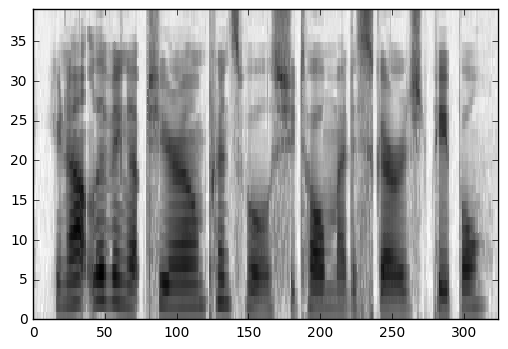

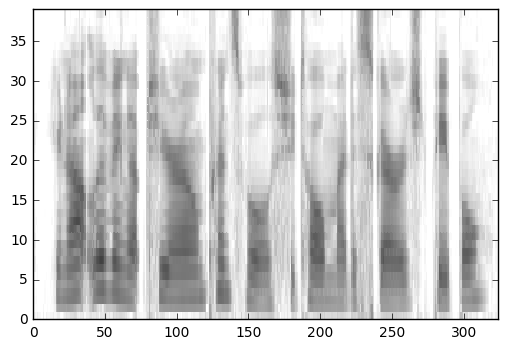

In [48]:
import matplotlib.colors as colors
x, y = np.mgrid[slice(0, my_mel40.shape[0]), slice(0, 40)]
plt.figure()
plt.pcolormesh(x, y, my_mel40, cmap='Greys', norm=colors.LogNorm(vmin=my_mel40.min(), vmax=my_mel40.max()))
plt.xlim(0, my_mel40.shape[0])
plt.ylim(0, 39)
plt.figure()
plt.pcolormesh(x, y, ess_mel40, cmap='Greys', norm=colors.LogNorm(vmin=my_mel40.min(), vmax=my_mel40.max()))
plt.xlim(0, my_mel40.shape[0])
plt.ylim(0, 39)